<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-2-Kaggle-Challenge/blob/master/module2/assignment_kaggle_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [x] Continue to participate in our Kaggle challenge.
- [x] Try Ordinal Encoding.
- [x] Try a Random Forest Classifier.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [x] Add your own stretch goal(s) !
- [x] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [x] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [x] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/waterpumps/train_features.csv'), 
                 pd.read_csv('../data/waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/waterpumps/test_features.csv')
sample_submission = pd.read_csv('../data/waterpumps/sample_submission.csv')

### supporting definitions for data cleaning and wrangling

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Supporting definitions for Wrangle
# this will lower the high cardinality columns, removing much of the noise
def convert_top_100(col_list,df,train):
  for col in col_list:
    global col_top_100
    col_top_100 = train[col].value_counts().index[0:100] # get top 100 of train only, then apply mapping to df in question if applicable
    df[col] = df[col].apply(map_to_100)
  return df
    
def map_to_100(feat):
  if feat in col_top_100:
    return feat
  else:
    return 'other'


  
  
# The main data wrangling function
def wrangle(df):
  
  # Imputer maintains True False, instead of 1,0. I prefer 1 column instead of 4
  bool_cols = ['public_meeting','permit']
  for col in bool_cols:
    df[col] = df[col].fillna(df[col].value_counts().index[0]).astype(int)
                 
  # convert some values to booleans, fill in missing values, replace suspicious values with nans
  high_cardinality_cols = ['wpt_name','subvillage','installer','funder','ward']
  df = convert_top_100(high_cardinality_cols,df,train) # keep the data pure to the "train" data set
  
  df.scheme_manamement = df.scheme_management.fillna('None') # a 'None' category exists, so might as well change nan to None
  
   # change this large count of near-zero outliers to 0, then convert to nan
  df.latitude = df.latitude.replace(-2e-8,0).value_counts()
  
  cols_with_0 = ['latitude','longitude', 'population','construction_year'] # population 1 also exists
  for col in cols_with_0:
    df[col] = df[col].replace(0,np.nan)
    
  df.population = df.population.replace(1,np.nan)

                 
  # remove columns that are "obviously" irrelevant, have too many categorical features, or are redundant
  drop = ['id','date_recorded','num_private','recorded_by','extraction_type',
          'extraction_type_group','water_quality','quantity','source','source_type',
          'waterpoint_type','scheme_name',
          'payment','management']
  
  df = df.drop(columns = drop)
  
  return df

### split away relevant information

### clean and wrangle data

In [258]:
# separate out id columns
train_id = train.id # I don't think this is necessary, but I'm keeping train id
test_id = test.id

# Separate features and labels
train_features = train.drop(columns=['status_group'])
train_labels = train.status_group
test_features = test.copy() # renaming to keep consistancy in variable names

train_features_clean = wrangle(train_features)
test_features_clean = wrangle(test_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


### Split data and apply pipeline model

In [0]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline

In [0]:
X_train,X_val,y_train,y_val = train_test_split(train_features_clean,train_labels)

### Stretch: trying an ExtraTreesClassifier
(because I did random forest previously)

In [0]:
rf = make_pipeline(ce.OrdinalEncoder(),
                   SimpleImputer(),
                   ExtraTreesClassifier(n_estimators=300,max_depth=20))

In [313]:
rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'scheme_management',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'quality_group', 'quantity_group',
                                      'source_class', 'waterpoint_type_group'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknow...
                 ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                      criterion='gini', max_depth=20,
                                      max_features='auto', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                   

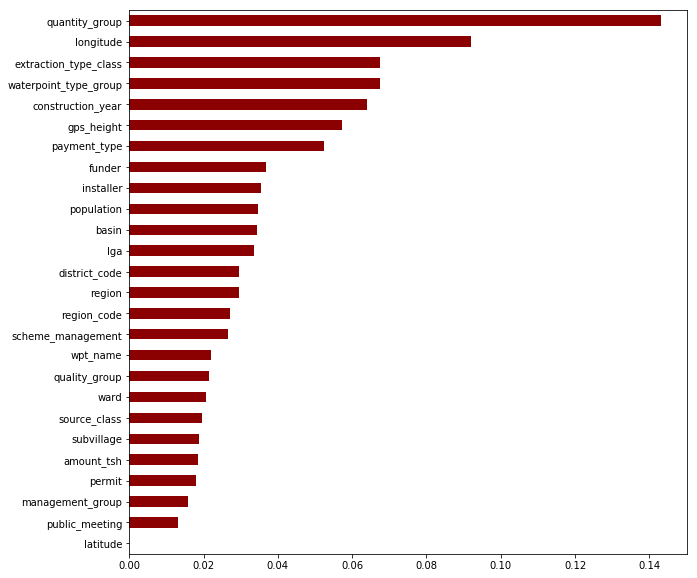

In [328]:
encoder = rf.named_steps['ordinalencoder']
important_features = encoder.transform(X_train).columns
model = rf.named_steps['extratreesclassifier']
feature_importance = model.feature_importances_

fig = plt.figure(figsize=(10,10))
pd.Series(feature_importance,important_features).sort_values().plot.barh(color='darkred');

### test on validation data and create prediction submission

In [314]:
rf.score(X_val,y_val)

0.8034343434343434

In [0]:
y_pred = rf.predict(test_features_clean)

In [0]:
submission = pd.concat([test_id,pd.Series(y_pred)],axis=1).rename(columns={0:'status_group'})
submission.to_csv("Trevor_Clack_waterpumps_sub3.csv",index=False)